# Сборный проект 2 Событийная аналитика

Для стартапа, продающего продукты питания, мне в качестве аналитика предстоит провести анализ событий, входящих в воронку продаж, для определения конверсии пользователей в последующие шаги и установления событий с наибольшим оттоком пользователей. Второй большой частью проекта будет проведение А/А/В тестирования между двумя контрольными и одной тестовой группой и оценка его результатов для проверки гипотезы эффективности внесения изменений в шрифт.
При выполнении проекта я планирую произвести следующие шаги:

    1. Ознакомиться с данными, их объемом и форматом.
    2. Провести предобработку данных, проверив их на пропуски и соответствие необходимым для анализа типам. При наличии обработать пропуски и привести данные к нужному формату, а также переименовать столбцы.
    3. На этапе исследовательского анализа данных выполнить следующие действия:
        - изучить имеющиеся в данных события, посчитать среднее количество событий на пользователя;
        - проанализировать временные рамки имеющихся данных, с помощью графика визуализации определить их полноту и по необходимости убрать неполные, определив истинный период проведения теста;
        - в случае удаления неполных данных оценить их долю в общем массиве для исключения значительного влияния на результаты тестирования.
    4. Изучить событийную воронку: определить последовательность событий воронки продаж, по необходимости убрав из анализа опциональные события, посчитать долю пользователей на каждом из шагов, а также выявить потери.
    5. Провести А/А/В тестирование, для начала оценив репрезентативность выборок на основе сравнения двух контрольных групп для выявления статистической значимости различий. Сравнить результаты тестовой группы с контрольными, при необходимости скорректировав уровень статистической значимости для проведения множественного анализа во избежание некорректного отвержения нулевой гипотезы, сделать необходимые выводы о возможной эффективности внесенных изменений.

## Первое знакомство с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import datetime as dt
import math as mth

In [2]:
sessions = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
display(sessions.head(5))
display(sessions.info())
sessions_shape = sessions.shape[0]

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Исходя из информации о датасете, в нашем распоряжении информация о более 240 тысячах событий, совершенных пользователями интернет-магазина. Для каждого события, кроме его названия, есть данные об идентификаторе пользователя, идентификаторе группы эксперимента, в которую попал пользователь, а также время совершения данного события.
Обращают на себя внимание не очень понятные названия столбцов, которые не отражают содержащиеся в них данные, а также тип данных в столбце с датой - целочисленный, то есть даты выражены целыми числами, не читабельны, их необходимо преобразовать в пригодный для анализа формат. В отдельную переменную сохранила первоначальное количество строк в датасете для расчета в дальнейшем доли оставшихся после отбрасывания ненужных данных.

## Предобработка данных

In [3]:
#переименование столбцов
sessions.rename(columns={'EventName' : 'event_name', 'DeviceIDHash' : 'user_id', 'EventTimestamp' : 'event_dt', 'ExpId' : 'group_id'}, inplace = True)
display(sessions.columns)

Index(['event_name', 'user_id', 'event_dt', 'group_id'], dtype='object')

In [4]:
#проверка пропусков и типов данных
display(sessions.isna().sum())

event_name    0
user_id       0
event_dt      0
group_id      0
dtype: int64

In [5]:
display(sessions.dtypes)

event_name    object
user_id        int64
event_dt       int64
group_id       int64
dtype: object

In [6]:
#изменение типа данных в столбце с датой
sessions['event_dt'] = pd.to_datetime(sessions['event_dt'], unit="s")
display(sessions['event_dt'].dtypes)

dtype('<M8[ns]')

In [7]:
#добавление столбца с датой
sessions['event_date'] = sessions['event_dt'].dt.date
display(sessions.head(5))

,event_name,user_id,event_dt,group_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [8]:
display(sessions[sessions.duplicated()])

,event_name,user_id,event_dt,group_id,event_date
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247,2019-08-01
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248,2019-08-01
...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247,2019-08-07
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07


In [9]:
sessions = sessions.drop_duplicates()
display(sessions.duplicated().sum())

0

In [10]:
updated_data_share = sessions.shape[0] / sessions_shape * 100
updated_data_share

99.83082506574475

В датасете 413 строк, являющихся полными дубликатами. Приняла решение их удалить как лишние для анализа, так как после их удаления остается больше 99% данных.

## Исследовательский анализ данных

In [11]:
display(sessions.shape[0])
display(sessions['event_name'].nunique())

243713

5

Нам доступны данные о пяти уникальных событиях, суммарно совершенных 243713 раза разными пользователями.

In [12]:
display(sessions['user_id'].nunique())

7551

В таблице данные о 7551 пользователей.

In [13]:
user_events = sessions.groupby('user_id').agg({'event_date' : 'count'}).reset_index().rename(columns={'user_id' : 'user_id', 'event_date' : 'events_number'})

display(user_events['events_number'].mean())

32.27559263673685

В среднем на пользователя приходится чуть больше 32 событий.

In [14]:
display(sessions['event_dt'].min(), sessions['event_dt'].max())

Timestamp('2019-07-25 04:43:36')

Timestamp('2019-08-07 21:15:17')

group_id,event_date,246,247,248
0,2019-07-25,4,1,4
1,2019-07-26,14,8,9
2,2019-07-27,24,23,8
3,2019-07-28,33,36,36
4,2019-07-29,55,58,71
5,2019-07-30,129,138,145
6,2019-07-31,620,664,746
7,2019-08-01,11561,12306,12274
8,2019-08-02,10946,10990,13618
9,2019-08-03,10575,11024,11683


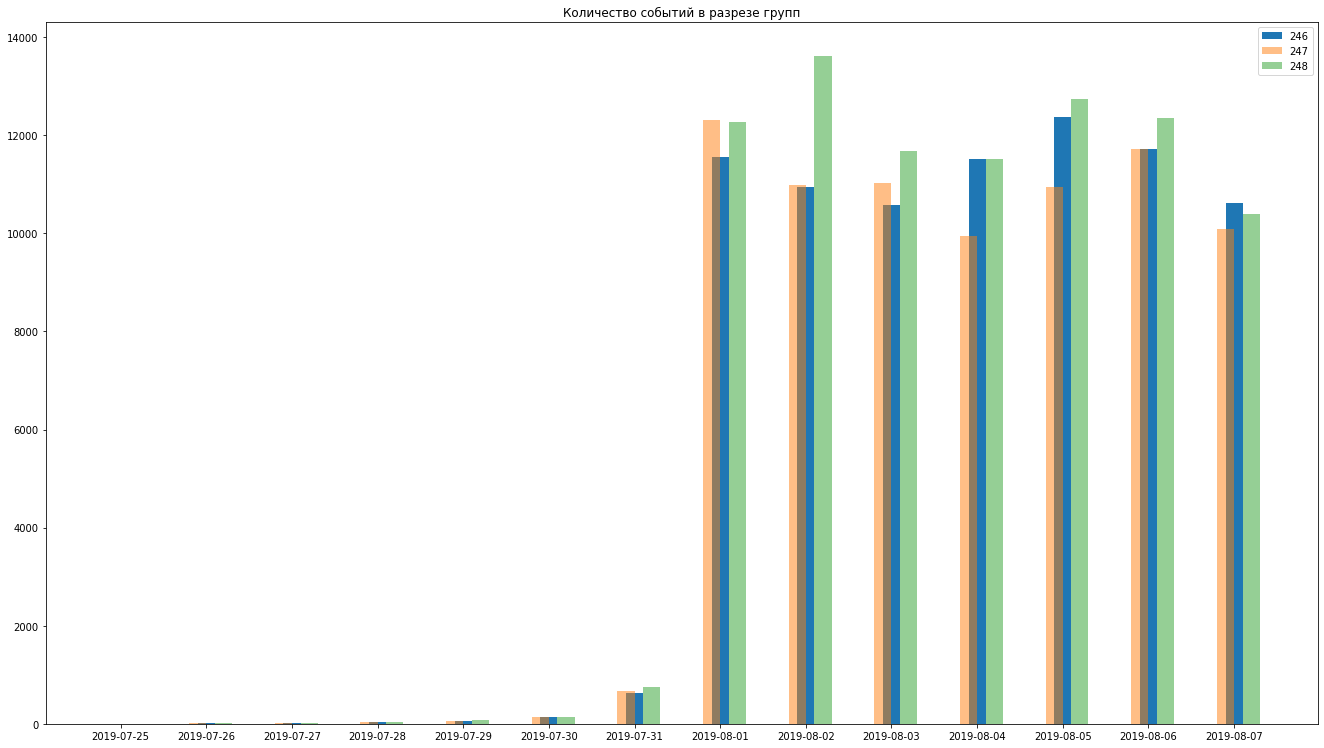

In [15]:
#столбчатая диаграмма количества событий в зависимости от времени в разрезе групп
grouped_data = sessions.pivot_table(index = 'event_date', columns = 'group_id', values = 'event_dt', aggfunc = 'count').reset_index()
display(grouped_data)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Количество событий в разрезе групп')
labels = grouped_data['event_date']
x = np.arange(len(grouped_data['event_date']))
y = grouped_data[246]
y1 = grouped_data[247]
y2 = grouped_data[248]
width = 0.2
plt.bar(x, y, width, label = '246')
plt.bar(x - width/2, y1, width, label = '247', align='center', alpha = 0.5)
plt.bar(x + width/2, y2, width, label = '248', align='edge', alpha = 0.5)
plt.xticks(np.arange(len(grouped_data['event_date'])))
ax.set_xticklabels(labels)
fig.tight_layout()
plt.legend()
plt.show()


На графике выше можно увидеть, что данные до 2019-07-30 представлены в единичных экземплярах, их очень мало. Можно предположить, что как раз эти данные для некоторых пользователей были "подтянуты" из прошлого, что создает некий перекос. Для дальнейшего анализа представляется логичным убрать эти события, предварительно оценив их долю в общем массиве.

In [16]:
incomplete_data = sessions.query("event_dt < '2019-08-01'")
display(incomplete_data.shape[0] / sessions.shape[0] * 100)

1.159560630741897

Доля данных о сессиях до 01 августа 2019 года составляет чуть больше 1% от общего массива, что позволяет изъять их из анализа.
Таким образом мы возьмем только полные данные за период с 2019-08-01 по 2019-08-07, то есть за неделю.

In [17]:
sessions_new = sessions.query("event_dt > '2019-08-01'")

display(sessions['user_id'].nunique() - sessions_new['user_id'].nunique(), sessions_new['user_id'].nunique() / sessions['user_id'].nunique() * 100)

17

99.77486425638989

В новом сете данных мы потеряли информацию о 17 пользователях, что также приемлемо, так как доля потерянных пользователей составляет менее 1% от общего количества.

Теперь необходимо проверить, присутствуют ли данные обо всех трех экспериментальных группах в обновленном датасете.

In [18]:
display(sessions_new.groupby('group_id').agg({'event_date' : 'count'}).reset_index())

,group_id,event_date
0,246,79302
1,247,77022
2,248,84563


В сгрупированной по трем группам таблице видно, что присутствуют записи о сессиях в каждой из них в сравнимом и применимом для дальнейшего анализа количестве.

## Изучаем воронку событий

In [19]:
#сортировка событий по частоте
display(sessions_new.groupby('event_name').agg({'event_date' : 'count'}).reset_index().rename(columns={'event_date' : 'events_number'}).sort_values(by = 'events_number', ascending = False))

,event_name,events_number
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Как видно в таблице выше, в таблице находятся данные о пяти различных событиях: MainScreenAppear - "Появление главного экрана", OffersScreenAppear - "Появление экрана с предложениями", CartScreenAppear - "Появление страницы корзины", PaymentScreenSuccessful - "Страница успешной оплаты", Tutorial - "Инструкция". Они отсортированы в порядке частоты встречаемости в данных. 

In [20]:
users_by_events = sessions_new.groupby('event_name').agg({'user_id' : 'nunique'}).reset_index().rename(columns={'user_id' : 'users_quantity'}).sort_values(by = 'users_quantity', ascending = False)
users_by_events['users_share'] = round(users_by_events['users_quantity'] / sessions_new['user_id'].nunique() * 100, 2)
display(users_by_events)

,event_name,users_quantity,users_share
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


В таблице выше мы видим количество пользователей, которые совершали каждое из пяти событий, а также долю в процентах от общего количества пользователей в обновленных данных.

Порядок и цепочка событий.
События предположительно выполняются в следующем порядке: сначало пользователь видит главный экран сайта - потом некоторые переходят на страницу с инструкцией/обучением (это событие может выполняться и на другом шаге) - далее пользователи открывают страницу с предложениями (где можно добавить товары в корзину) - потом переходят на страницу корзины, где можно оплатить заказ - последним событием пользователь видит страницу успешной оплаты. Просмотр инструкции - действие опциональное, как можно видеть из расчета количества пользователей, совершающих его, а также с неопределенным порядком в цепочке событий, поэтому его можно убрать из расчета воронки.

In [21]:
#расчет доли пользователей, которые переходят на следующий шаг
users_by_events = users_by_events.drop(4)
users_by_events['next_step_quantity'] = users_by_events['users_quantity'].shift()
users_by_events['next_step_share'] = round(users_by_events['users_quantity'] / users_by_events['next_step_quantity'] * 100, 2)
display(users_by_events)

,event_name,users_quantity,users_share,next_step_quantity,next_step_share
1,MainScreenAppear,7419,98.47,NaN,NaN
2,OffersScreenAppear,4593,60.96,7419.0,61.91
0,CartScreenAppear,3734,49.56,4593.0,81.30
3,PaymentScreenSuccessful,3539,46.97,3734.0,94.78


Из приведенной выше таблицы с расчетами доли пользователей, которые переходят на следующий шаг, можно сделать вывод о том, что больше всего пользователей терятся на первом шаге, то есть при переходе с главной страницы сайта на страницу с предложениями. Данное наблюдение требует дальнейшего исследования для нахождения возможных причин.

In [22]:
buyers_share = users_by_events.loc[3, 'users_quantity'] / users_by_events.loc[1, 'users_quantity'] * 100
display(buyers_share)

47.70184661005526

Расчеты выше помогают нам понять, что чуть менее половины пользователей (47.7%), пришедших на сайт, становятся покупателями и совершают оплату.

## Проведение и анализ результатов A/A/B теста

### A/A тестирование для сравнения двух контрольных групп

**Нулевая гипотеза H0:** - нет разницы между долями разных групп пользователей

**Альтернативная гипотеза H1:** - разница между группами пользователей обладает статистической значимостью

**Суммарный уровень статистической значимости α** = 0.05

Проводим **z-тестирование** для сравнения пропорций пользователей в группах, выполнивших каждое последовательное событие воронки продаж, к общему количеству пользователей в группе.

In [23]:
display(sessions_new.groupby('group_id').agg({'user_id' : 'nunique'}).reset_index())

,group_id,user_id
0,246,2484
1,247,2513
2,248,2537


Таблица выше отображает количество уникальных пользователей в каждой экспериментальной группе (около 2500 в каждой группе). Теперь необходимо проверить, не попали ли события, совершенные одним и тем же пользователем, в разные группы.

In [24]:
display(sessions_new.pivot_table(index='user_id', values='group_id', aggfunc='nunique').sort_values(by = 'group_id', ascending = False))

,group_id
user_id,
6888746892508752,1
6204944347213293942,1
6215559225876063378,1
6215162890135937308,1
6213626876710715478,1
...,...
3171454373076660766,1
3170212200647575044,1
3167974726645136146,1


Посчитав количество уникальных идентификаторов групп у каждого пользователя и расположив их в порядке убывания, мы можем увидеть, что максимальное количество групп каждого пользователя равно единице, как это и должно быть при корректном тестировании и делении пользователей на группы.

In [25]:
users246_by_events = sessions_new[sessions_new['group_id'] == 246].groupby('event_name').agg({'user_id' : 'nunique'}).reset_index().rename(columns={'user_id' : 'users_quantity'}).sort_values(by = 'users_quantity', ascending = False)
users246_by_events['total_users'] = sessions_new[sessions_new['group_id'] == 246]['user_id'].nunique()
users246_by_events = users246_by_events.set_index('event_name').drop('Tutorial')
display(users246_by_events)

,users_quantity,total_users
event_name,,
MainScreenAppear,2450,2484
OffersScreenAppear,1542,2484
CartScreenAppear,1266,2484
PaymentScreenSuccessful,1200,2484


In [26]:
users247_by_events = sessions_new[sessions_new['group_id'] == 247].groupby('event_name').agg({'user_id' : 'nunique'}).reset_index().rename(columns={'user_id' : 'users_quantity'}).sort_values(by = 'users_quantity', ascending = False)
users247_by_events['total_users'] = sessions_new[sessions_new['group_id'] == 247]['user_id'].nunique()
users247_by_events = users247_by_events.set_index('event_name').drop('Tutorial')
display(users247_by_events)

,users_quantity,total_users
event_name,,
MainScreenAppear,2476,2513
OffersScreenAppear,1520,2513
CartScreenAppear,1238,2513
PaymentScreenSuccessful,1158,2513


In [27]:
def get_z_results(df1, df2, event_name1):
    alpha = 0.05  # критический уровень статистической значимости
    next_step = np.array([df1.loc[event_name1, 'users_quantity'], df2.loc[event_name1, 'users_quantity']])
    total_users = np.array([df1.loc[event_name1, 'total_users'], df2.loc[event_name1, 'total_users']])

# ваш код

# пропорция успехов в первой группе:
    p1 = next_step[0]/total_users[0]

# пропорция успехов во второй группе:
    p2 = next_step[1]/total_users[1]
    
# пропорция успехов в комбинированном датасете:
    p_combined = (next_step[0] + next_step[1]) / (total_users[0] + total_users[1])

# разница пропорций в датасетах
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users[0] + 1/total_users[1]))

# ваш код
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2 # ваш код

    print('p-значение: ', p_value)

    if p_value < alpha: # ваш код
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

In [28]:
get_z_results(users246_by_events, users247_by_events, event_name1 = 'MainScreenAppear')

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [29]:
get_z_results(users246_by_events, users247_by_events, event_name1 = 'OffersScreenAppear')

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [30]:
get_z_results(users246_by_events, users247_by_events, event_name1 = 'CartScreenAppear')

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [31]:
get_z_results(users246_by_events, users247_by_events, event_name1 = 'PaymentScreenSuccessful')

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [32]:
#число и доля пользователей, совершивших событие в каждой из контрольных групп
users246_by_events['users_share'] = users246_by_events['users_quantity'] / users246_by_events['total_users'] * 100
users247_by_events['users_share'] = users247_by_events['users_quantity'] / users247_by_events['total_users'] * 100
display(users246_by_events, users247_by_events)

,users_quantity,total_users,users_share
event_name,,,
MainScreenAppear,2450,2484,98.631240
OffersScreenAppear,1542,2484,62.077295
CartScreenAppear,1266,2484,50.966184
PaymentScreenSuccessful,1200,2484,48.309179


,users_quantity,total_users,users_share
event_name,,,
MainScreenAppear,2476,2513,98.527656
OffersScreenAppear,1520,2513,60.485476
CartScreenAppear,1238,2513,49.263828
PaymentScreenSuccessful,1158,2513,46.080382


Произведенные выше расчеты значений p-value и сделанные выводы позволяют нам считать две контрольные группы близкими по показателям, а значит, выборка сделана корректно.

### А/В тестирование для сравнения с тестовой группой

**Нулевая гипотеза H0:** - нет разницы между долями разных групп пользователей

**Альтернативная гипотеза H1:** - разница между группами пользователей обладает статистической значимостью

**Суммарный уровень статистической значимости α** = 0.05
**Уровень статистической значимости α после применения поправки Шидака** = 0.004

Проводим **z-тестирование** для сравнения пропорций пользователей в группах, выполнивших каждое последовательное событие воронки продаж, к общему количеству пользователей в группе.

In [33]:
#сравнение с тестовой группой
users248_by_events = sessions_new[sessions_new['group_id'] == 248].groupby('event_name').agg({'user_id' : 'nunique'}).reset_index().rename(columns={'user_id' : 'users_quantity'}).sort_values(by = 'users_quantity', ascending = False)
users248_by_events['total_users'] = sessions_new[sessions_new['group_id'] == 248]['user_id'].nunique()
users248_by_events = users248_by_events.set_index('event_name').drop('Tutorial')
users248_by_events['users_share'] = users248_by_events['users_quantity'] / users248_by_events['total_users'] * 100
display(users248_by_events)

,users_quantity,total_users,users_share
event_name,,,
MainScreenAppear,2493,2537,98.265668
OffersScreenAppear,1531,2537,60.346866
CartScreenAppear,1230,2537,48.482460
PaymentScreenSuccessful,1181,2537,46.551045


In [34]:
#объединение контрольных групп
users246247_by_events = users246_by_events + users247_by_events
users246247_by_events['users_share'] = users246247_by_events['users_quantity'] / users246247_by_events['total_users'] * 100
display(users246247_by_events)

,users_quantity,total_users,users_share
event_name,,,
MainScreenAppear,4926,4997,98.579147
OffersScreenAppear,3062,4997,61.276766
CartScreenAppear,2504,4997,50.110066
PaymentScreenSuccessful,2358,4997,47.188313


In [35]:
get_z_results(users246_by_events, users248_by_events, event_name1 = 'MainScreenAppear')

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [36]:
get_z_results(users246_by_events, users248_by_events, event_name1 = 'OffersScreenAppear')

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [37]:
get_z_results(users246_by_events, users248_by_events, event_name1 = 'CartScreenAppear')

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [38]:
get_z_results(users246_by_events, users248_by_events, event_name1 = 'PaymentScreenSuccessful')

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [39]:
get_z_results(users247_by_events, users248_by_events, event_name1 = 'MainScreenAppear')

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [40]:
get_z_results(users247_by_events, users248_by_events, event_name1 = 'OffersScreenAppear')

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [41]:
get_z_results(users247_by_events, users248_by_events, event_name1 = 'CartScreenAppear')

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [42]:
get_z_results(users247_by_events, users248_by_events, event_name1 = 'PaymentScreenSuccessful')

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [43]:
get_z_results(users246247_by_events, users248_by_events, event_name1 = 'MainScreenAppear')

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [44]:
get_z_results(users246247_by_events, users248_by_events, event_name1 = 'OffersScreenAppear')

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [45]:
get_z_results(users246247_by_events, users248_by_events, event_name1 = 'CartScreenAppear')

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [46]:
get_z_results(users246247_by_events, users248_by_events, event_name1 = 'PaymentScreenSuccessful')

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Ни один из проведенных 12 z-тестов не дал возможности отвергнуть нулевую гипотезу о равенстве долей, следовательно, говорить об ошибке первого рода не имеет смысла. Все это предположительно приводит к мысли о неэффективности гипотезы и отсутствии необходимости дальнейшего проведения теста, так как значимых результатов он не показал.

In [47]:
#поправка уровня статистической значимости 12 проверок
m = 12
alpha = 0.05
alpha_sidak = 1 - (1 - alpha) ** (1/m)
fwer_sidak = 1 - (1 - alpha_sidak) ** m
alpha_sidak, fwer_sidak

(0.004265318777560645, 0.04999999999999971)

После проведения множественных проверок на одних и тех же данных, как правило, повышается вероятность ошибки первого рода (то есть отвергнуть нулевую гипотезу некорректно). Уменьшив уровень значимости единичной проверки с помощью метода Шидака (до 0.004), мы снижаем вероятность ошибки первого рода и оставляем суммарный уровень значимости всех проверок на прежнем уровне (стремится к 0.5). В данном конкретном случае замена значения alpha в каждом из проводимых тестов не поменяла результатов, так как ни одна нулевая гипотеза не оказалась отвергнутой.

## Итоговый вывод

Все запланированные вначале этапы проектной работы выполнены.

    1. Пропуски отсутствуют, тип данных в столбце с датой приведен к нужному формату.
    2. Определено среднее количество событий на пользователя (чуть более 32), а также минимальная и максимальная дата имеющихся в таблице событий.
    3. Отброшено менее 2% событий из общего массива данных, которые выполнены менее 1% пользователей, для очищения датасета от неполных данных. Таким образом для анализа оказались представлены данные о проведении теста за неделю с 01 по 07 августа 2019 года.
    4. При изучении воронки продаж определены пять событий в датасете, их порядок. Событие Tutorial исключено из анализа, так как не являтся частью последовательного процесса, который проходит пользователь на сайте при совершении покупок, является опциональным и выполяется небольшим процентом пользователей.
    5. Рассчитаны доли конверсии пользователей, которые переходят на каждый последующий шаг, на первом шаге перехода из первого события во второе теряется наибольшее количество посетителей сайта.
    6. После проведения АА тестирования для сравнения двух контрольных групп 246 и 247 сделаны выводы о корректности выборок в датасете и отвергнуты гипотезы о статистической значимости различий между ними.
    7. Расчет результатов АВ тестирования для сравнения контрольных групп с тестовой 248 также не показал статистически значимых результатов. Нет основания отвергнуть ни одну нулевую гипотезу о равенстве групп.
    
Таким образом, тестирование можно завершить и признать гипотезу о влиянии изменении шрифта на увеличение количество пользователей сайта неэффективной.